In [1]:
import pandas as pd
import numpy as np
import csv
import ast
import matplotlib.pyplot as plt
#videodata=pd.read_csv('/Users/mac/Documents/Insight project/video_database_schon.csv')
videodata1=pd.read_csv('/Users/mac/Documents/Insight project/sound_database_schon.csv')
#print(videodata1.columns)
videodata2=pd.read_csv('/Users/mac/Documents/Insight project/sound_database_romance.csv')
#print(videodata2.columns)
videodata3=pd.read_csv('/Users/mac/Documents/Insight project/sound_database_ysaye.csv')
#print(videodata3.columns)
videodata4=pd.read_csv('/Users/mac/Documents/Insight project/sound_database_zapa.csv')
#print(videodata4.columns)
videodata5=pd.read_csv('/Users/mac/Documents/Insight project/sound_database_brahms.csv')
#print(videodata4.columns)
videodata=pd.concat([videodata1,videodata2,videodata3,videodata4,videodata5],sort=True,ignore_index=True)

#Check for duplicates from API search process
print(len(videodata['VideoId'].unique()))
videodata=videodata.drop(['dailyviewspersubscriber'],axis=1)
videodata=videodata.drop(['Unnamed: 0'],axis=1)
videodata=videodata.drop(['Unnamed: 0.1'],axis=1)
videodata=videodata.drop(['VideoId.1'],axis=1)
videodata=videodata.loc[:, ~videodata.columns.str.startswith('max_')]
videodata=videodata.loc[:, ~videodata.columns.str.startswith('min_')]
videodata=videodata.loc[:, ~videodata.columns.str.startswith('25%_')]
videodata=videodata.loc[:, ~videodata.columns.str.startswith('50%_')]
videodata=videodata.loc[:, ~videodata.columns.str.startswith('75%_')]
#print(videodata['Description'])
videodata=videodata.drop_duplicates(subset=['VideoId'], keep='first', inplace=False)
from datetime import datetime
a=datetime(2018,9,25,hour=0, minute=0, second=0, microsecond=0)
videodata['publishedAt']=videodata['publishedAt'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
videodata['dayslive']=a-videodata['publishedAt']
videodata['dayslive']=videodata['dayslive'].apply(lambda x: (x.days * 86400 + x.seconds)/86400)
videodata['Description']=videodata['Description'].astype(str)
videodata['Title']=videodata['Title'].astype(str)
videodata['tags']=videodata['tags'].replace(np.nan, '[]', regex=True)
videodata['tags']=videodata['tags'].apply(lambda x: ast.literal_eval(x))
videodata['VideoId']=videodata['VideoId'].astype(str)
videodata['dailyviewspersubscriber']=videodata['viewCount']/((videodata['dayslive']+0.01)*(0.01+videodata['channelSubscribers']))
videodata['dailyviews']=videodata['viewCount']/(videodata['dayslive']+0.01)

2625


In [2]:
from nltk import word_tokenize, pos_tag, ne_chunk
import nltk
from collections import Counter
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
#Count mentions of named entities in description, title

def count_ne(example):
    y=pos_tag(word_tokenize(example))
    counts = Counter(tag for word,tag in y)
    return counts['NNP']
videodata['Description_ne_counts']= list(map(lambda x: count_ne(x), videodata['Description']))
videodata['Title_ne_counts']= list(map(lambda x: count_ne(x), videodata['Title']))
def count_ne_tags(example):
    ind=0
    for item in example:
        y=pos_tag(word_tokenize(item))
        counts = Counter(tag for word,tag in y)
        if counts['NNP']>0: 
            ind+=1
    return ind
videodata['tags_ne_counts']= list(map(lambda x: count_ne_tags(x), videodata['tags']))
#1. remove capital letters
#2. count mentions of instruments, famous artists, etc.
#3. detect mentions of people, orgs
#4. detect mentions of piece number information
import string
translator = str.maketrans('', '', string.punctuation)
videodata['tags'] = list(map(lambda x: [item.lower() for item in x], videodata['tags']))
videodata['Title'] = list(map(lambda x: x.translate(translator).lower(), videodata['Title']))
videodata['Description'] = list(map(lambda x: x.translate(translator).lower(), videodata['Description']))
#remove special characters
textrefs=pd.read_csv('/Users/mac/Documents/Insight project/Text lists.csv')
composers=textrefs['Composer last name'].dropna()
composers=list(map(lambda x: x.lower().rstrip(),composers))
artists=textrefs['Famous violinists and pianists'].dropna()
artists=list(map(lambda x: x.lower().rstrip(),artists))
instruments=textrefs['Musical instrument'].dropna()
instruments=list(map(lambda x: x.lower().rstrip(),instruments))
genres=textrefs['Genre'].dropna()
genres=list(map(lambda x: x.lower().rstrip(),genres))
piece=textrefs['Piece type'].dropna()
piece=list(map(lambda x: x.lower().rstrip(),piece))
complete=textrefs['completeness'].dropna()
complete=list(map(lambda x: x.lower().rstrip(),complete))
def count_vars(example,elements):
    c=Counter(example.split())
    num=0
    for word in elements:
        num+=c[str(word)]
    return num
def count_vars_tags(example,elements):
    c=Counter(example)
    num=0
    for word in elements:
        num+=c[str(word)]
    return num
#count_vars(videodata['Description'][0],composers)
videodata['tags_composer'] = list(map(lambda x: count_vars_tags(x,composers), videodata['tags']))
videodata['Title_composer'] = list(map(lambda x: count_vars(x,composers), videodata['Title']))
videodata['Description_composer'] = list(map(lambda x: count_vars(x,composers), videodata['Description']))
videodata['tags_artists'] = list(map(lambda x: count_vars_tags(x,artists), videodata['tags']))
videodata['Title_artists'] = list(map(lambda x: count_vars(x,artists), videodata['Title']))
videodata['Description_artists'] = list(map(lambda x: count_vars(x,artists), videodata['Description']))
videodata['tags_instruments'] = list(map(lambda x: count_vars_tags(x,instruments), videodata['tags']))
videodata['Title_instruments'] = list(map(lambda x: count_vars(x,instruments), videodata['Title']))
videodata['Description_instruments'] = list(map(lambda x: count_vars(x,instruments), videodata['Description']))
videodata['tags_genres'] = list(map(lambda x: count_vars_tags(x,genres), videodata['tags']))
videodata['Title_genres'] = list(map(lambda x: count_vars(x,genres), videodata['Title']))
videodata['Description_genres'] = list(map(lambda x: count_vars(x,genres), videodata['Description']))
videodata['tags_piece'] = list(map(lambda x: count_vars_tags(x,piece), videodata['tags']))
videodata['Title_piece'] = list(map(lambda x: count_vars(x,piece), videodata['Title']))
videodata['Description_piece'] = list(map(lambda x: count_vars(x,piece), videodata['Description']))
videodata['tags_complete'] = list(map(lambda x: count_vars_tags(x,complete), videodata['tags']))
videodata['Title_complete'] = list(map(lambda x: count_vars(x,complete), videodata['Title']))
videodata['Description_complete'] = list(map(lambda x: count_vars(x,complete), videodata['Description']))
videodata['tags_count']=list(map(lambda x: len(x), videodata['tags']))
videodata['Title_length']=list(map(lambda x: len(x), videodata['Title']))

In [3]:
from textblob import TextBlob
videodata['Title_pos']=list(map(lambda x: TextBlob(x).sentiment[0], videodata['Title']))
videodata['Description_pos']=list(map(lambda x: TextBlob(x).sentiment[0], videodata['Description']))
videodata['tags_pos']=list(map(lambda x: TextBlob(" ".join(str(i) for i in x)).sentiment[0], videodata['tags']))
#videodata['tags_pos'].describe()

In [4]:
print(videodata['std_chroma_std'].isna().sum())
videodata=videodata.dropna()
print(videodata['std_chroma_std'].isna().sum())


1
0


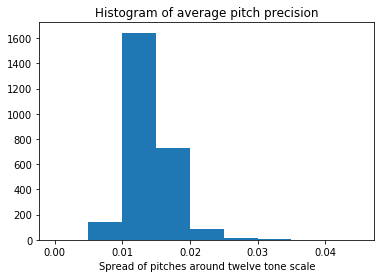

14      2QBlSWJ-y60
239     pjlYQJl0haQ
275     jmQWm40kaos
402     lRH9MC6w1uE
471     2FsilL3uwPQ
502     7-t6RAAIcpU
974     t_AG60OBVbM
1321    sDBXtJTokfc
1395    nrSu3TYRxgI
1763    beXSvJGeNtQ
1789    IHf95AoPhr0
1812    6VHE6lmKt7U
2307    nVOskj0HKtw
2361    fYfMB92b7Ac
2536    Szdziw4tI9o
Name: VideoId, dtype: object


In [5]:
import matplotlib.pyplot as plt
#Histograms to look for shape of distribution
bin_values=np.arange(start=0, stop=0.05,step=0.005)
plt.hist(videodata['std_chroma_std'],bins=bin_values)
plt.xlabel('Spread of pitches around twelve tone scale')
plt.title('Histogram of average pitch precision')
plt.show()
print(videodata['VideoId'][videodata['std_chroma_std']>0.025])


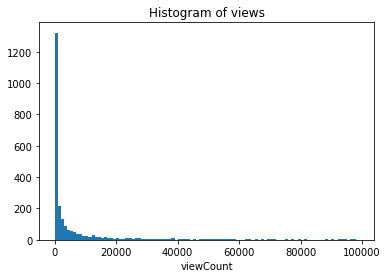

In [6]:
import matplotlib.pyplot as plt
#Histograms to look for shape of distribution
bin_values=np.arange(start=0, stop=100000,step=1000)
plt.hist(videodata['viewCount'],bins=bin_values)
plt.xlabel('viewCount')
plt.title('Histogram of views')
plt.show()
#So out of 2625 videos, more than 700 have no views
#->predict whether a video has any views with a classifier
videodata_orig_noPCA=videodata.copy()
#videodata.isna().sum()

In [7]:
videodata=videodata_orig_noPCA.copy()

In [8]:
#Optional PCA on audio features
videodata=videodata.dropna()
from sklearn.decomposition import PCA
import pickle
Xmfcc=videodata[['mean_mfcc_1','mean_mfcc_2','mean_mfcc_3','mean_mfcc_4','mean_mfcc_5','mean_mfcc_6','mean_mfcc_7','mean_mfcc_8','mean_mfcc_9','mean_mfcc_10','mean_mfcc_11','mean_mfcc_12','mean_mfcc_13','std_mfcc_1','std_mfcc_2','std_mfcc_3','std_mfcc_4','std_mfcc_5','std_mfcc_6','std_mfcc_7','std_mfcc_8','std_mfcc_9','std_mfcc_10','std_mfcc_11','std_mfcc_12','std_mfcc_13']]
pca = PCA(n_components=3)
Xreg=pca.fit_transform(Xmfcc)
filename = 'pca_model_mfcc.sav'
#pickle.dump(pca, open(filename, 'wb'))
#When I have new data, run Xreg_new = pca.transform(X_new) to project onto PCA coordinates
print(pca.explained_variance_ratio_)
mfccdata=pd.DataFrame(Xreg,columns=['mfccPC1','mfccPC2','mfccPC3'])
videodata=videodata.drop(['mean_mfcc_1','mean_mfcc_2','mean_mfcc_3','mean_mfcc_4','mean_mfcc_5','mean_mfcc_6','mean_mfcc_7','mean_mfcc_8','mean_mfcc_9','mean_mfcc_10','mean_mfcc_11','mean_mfcc_12','mean_mfcc_13','std_mfcc_1','std_mfcc_2','std_mfcc_3','std_mfcc_4','std_mfcc_5','std_mfcc_6','std_mfcc_7','std_mfcc_8','std_mfcc_9','std_mfcc_10','std_mfcc_11','std_mfcc_12','std_mfcc_13'],axis=1)
videodata.reset_index(drop=True, inplace=True)
mfccdata.reset_index(drop=True, inplace=True)
videodata=pd.concat([videodata,mfccdata],axis=1)

Ychroma=videodata[['mean_chroma_1','mean_chroma_2','mean_chroma_3','mean_chroma_4','mean_chroma_5','mean_chroma_6','mean_chroma_7','mean_chroma_8','mean_chroma_9','mean_chroma_10','mean_chroma_11','mean_chroma_12','std_chroma_1','std_chroma_2','std_chroma_3','std_chroma_4','std_chroma_5','std_chroma_6','std_chroma_7','std_chroma_8','std_chroma_9','std_chroma_10','std_chroma_11','std_chroma_12']]
Ychroma=Ychroma.dropna()
pca2 = PCA(n_components=6)
Yreg=pca2.fit_transform(Ychroma)
filename = 'pca2_model_chroma.sav'
#pickle.dump(pca2, open(filename, 'wb'))
#When I have new data, run Yreg_new = pca2.transform(Y_new) to project onto PCA coordinates
print(pca2.explained_variance_ratio_)
chromadata=pd.DataFrame(Yreg,columns=['chromaPC1','chromaPC2','chromaPC3','chromaPC4','chromaPC5','chromaPC6'])
videodata=videodata.drop(['mean_chroma_1','mean_chroma_2','mean_chroma_3','mean_chroma_4','mean_chroma_5','mean_chroma_6','mean_chroma_7','mean_chroma_8','mean_chroma_9','mean_chroma_10','mean_chroma_11','mean_chroma_12','std_chroma_1','std_chroma_2','std_chroma_3','std_chroma_4','std_chroma_5','std_chroma_6','std_chroma_7','std_chroma_8','std_chroma_9','std_chroma_10','std_chroma_11','std_chroma_12'],axis=1)
videodata.reset_index(drop=True, inplace=True)
chromadata.reset_index(drop=True, inplace=True)
videodata=pd.concat([videodata,chromadata],axis=1)
print(videodata.shape)
videodata.isna().sum()
videodata.columns

[0.65176753 0.19561255 0.09745317]
[0.26694099 0.12426333 0.11053196 0.09442178 0.07064258 0.0639547 ]
(2624, 65)


Index(['Desc_word_count', 'Description', 'Title', 'VideoId', 'channelID',
       'channelSubscribers', 'dailyviews', 'mean_chroma_std', 'mean_energy',
       'mean_energy_entropy', 'mean_spectral_centroid',
       'mean_spectral_entropy', 'mean_spectral_flux', 'mean_spectral_rolloff',
       'mean_spectral_spread', 'mean_zcr', 'publishedAt', 'std_chroma_std',
       'std_energy', 'std_energy_entropy', 'std_spectral_centroid',
       'std_spectral_entropy', 'std_spectral_flux', 'std_spectral_rolloff',
       'std_spectral_spread', 'std_zcr', 'tags', 'viewCount', 'dayslive',
       'dailyviewspersubscriber', 'Description_ne_counts', 'Title_ne_counts',
       'tags_ne_counts', 'tags_composer', 'Title_composer',
       'Description_composer', 'tags_artists', 'Title_artists',
       'Description_artists', 'tags_instruments', 'Title_instruments',
       'Description_instruments', 'tags_genres', 'Title_genres',
       'Description_genres', 'tags_piece', 'Title_piece', 'Description_piece',
   

In [11]:
#Interpret PCA
mfcc_loadings = np.sqrt(pca.explained_variance_[0])*pca.components_
mfcc_loadings=pd.DataFrame(mfcc_loadings)
mfcc_loadings=mfcc_loadings.transpose()
mfcc_loadings.columns=['mfccPC1','mfccPC2', 'mfccPC3']
mfcc_loadings['Label']=Xmfcc.columns
#print(mfcc_loadings)

chroma_loadings = np.sqrt(pca2.explained_variance_[0])*pca2.components_
chroma_loadings=pd.DataFrame(chroma_loadings)
chroma_loadings=chroma_loadings.transpose()
chroma_loadings.columns=['chromaPC1','chromaPC2', 'chromaPC3','chromaPC4','chromaPC5', 'chromaPC6']
chroma_loadings['Label']=Ychroma.columns
#print(chroma_loadings)

In [9]:
#CREATE CLASSIFIER LABEL
print(videodata.shape)
#Create a classifier variable equal to 1 if viewCount is greater than 1, 0 otherwise
videodata['views_cat'] = np.where(videodata['viewCount']<200, 0, 1) #100#500
#Maybe create another category for viral videos
videodata.loc[videodata['viewCount'] >=2000, 'views_cat'] = 2 #20000#10000
videodata.loc[videodata['viewCount'] >=20000, 'views_cat'] = 3 #20000#10000
#videodata=videodata.dropna()
print(videodata.shape)
videodata=videodata.drop(['publishedAt'],axis=1)

(2624, 65)
(2624, 66)


In [31]:
print(videodata['std_chroma_std'].loc[videodata['viewCount']<200].mean())
print(videodata['std_chroma_std'].loc[videodata['viewCount']>200].mean())
print(videodata['std_chroma_std'].loc[videodata['viewCount']>2000].mean())
print(videodata['std_chroma_std'].loc[videodata['viewCount']>20000].mean())


0.014713927422115606
0.013740132230538781
0.01369194655214374
0.013358111340544904


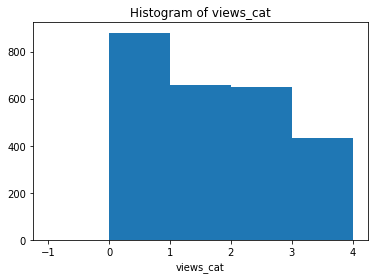

In [24]:
import matplotlib.pyplot as plt
#Histograms to look for shape of distribution
bin_values=np.arange(start=-1, stop=5,step=1)
plt.hist(videodata['views_cat'],bins=bin_values)
plt.xlabel('views_cat')
plt.title('Histogram of views_cat')
plt.show()
#So out of 2625 videos, more than 700 have no views
#->predict whether a video has any views with a classifier

In [25]:
#Feature selection #1
targ=videodata['views_cat']
y = np.array(targ).astype(int)
#y=videodata['views_cat']
#X=videodata.drop(['Title','Description','tags','publishedAt','VideoId','channelID','views_cat','dailyviews','viewCount','dailyviewspersubscriber'],axis=1).astype(int)
X=videodata.drop(['Title','Description','tags','VideoId','channelID','views_cat','dailyviews','viewCount','dailyviewspersubscriber'],axis=1).astype(int)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 25)
rfe = rfe.fit(X, y)
print(X.columns[rfe.support_])
print(rfe.ranking_)

Index(['Desc_word_count', 'mean_energy_entropy', 'mean_spectral_entropy',
       'std_energy_entropy', 'Description_ne_counts', 'Title_ne_counts',
       'tags_composer', 'Title_composer', 'Description_composer',
       'tags_artists', 'Title_artists', 'Description_artists',
       'tags_instruments', 'Title_instruments', 'Description_instruments',
       'tags_genres', 'Title_genres', 'Description_genres', 'tags_count',
       'Title_pos', 'Description_pos', 'tags_pos', 'mfccPC1', 'mfccPC2',
       'mfccPC3'],
      dtype='object')
[ 1  5  9  8  1  7  1  6 11 13 15 18 10  1 21 24 26 17 12 23  4  1  1  2
  1  1  1  1  1  1  1  1  1  1  1  1 16 20 19 22 25 14  1  3  1  1  1  1
  1  1 27 28 29 30 31 32]


In [27]:
#Feature selection method #2
x=videodata[videodata['views_cat']==1].mean()-videodata[videodata['views_cat']==0].mean()
#videodata_reduced=videodata.drop(['Title','Description','tags','publishedAt','VideoId','channelID','dailyviews','viewCount','dailyviewspersubscriber'],axis=1)
videodata_reduced=videodata.drop(['Title','Description','tags','VideoId','channelID','dailyviews','viewCount','dailyviewspersubscriber'],axis=1)
print(x.shape)
print(len(videodata_reduced.columns))
#print(videodata[videodata['views_cat']==0].mean())
videodata_reduced=videodata_reduced.loc[:, abs(x)>0.02]
print(videodata_reduced.columns)

(60,)
57
Index(['Desc_word_count', 'channelSubscribers', 'mean_spectral_entropy',
       'std_spectral_entropy', 'dayslive', 'Description_ne_counts',
       'Title_ne_counts', 'tags_ne_counts', 'tags_composer', 'Title_composer',
       'Description_composer', 'tags_artists', 'Title_artists',
       'tags_instruments', 'Title_instruments', 'Description_instruments',
       'tags_count', 'Title_length', 'Description_pos', 'mfccPC1', 'mfccPC2',
       'mfccPC3', 'views_cat'],
      dtype='object')


In [28]:
#np.isnan(videodata_reduced).describe()
z=videodata[videodata['views_cat']==1].mean()-videodata[videodata['views_cat']==2].mean()
#videodata_reduced=videodata.drop(['Title','Description','tags','publishedAt','VideoId','channelID','dailyviews','viewCount','dailyviewspersubscriber'],axis=1)
videodata_reduced=videodata.drop(['Title','Description','tags','VideoId','channelID','dailyviews','viewCount','dailyviewspersubscriber'],axis=1)
#videodata_reduced=videodata.drop(['Title','Description','tags','VideoId','channelID','dailyviews','dailyviewspersubscriber'],axis=1) #uncat
print(z.shape)
print(len(videodata_reduced.columns))
#print(videodata[videodata['views_cat']==0].mean())
videodata_reduced=videodata_reduced.loc[:, abs(z)>0.015]
print(videodata_reduced.columns)

(60,)
57
Index(['Desc_word_count', 'channelSubscribers', 'dayslive',
       'Description_ne_counts', 'Title_ne_counts', 'tags_ne_counts',
       'tags_composer', 'Title_composer', 'Description_composer',
       'tags_artists', 'Title_artists', 'Description_artists',
       'tags_instruments', 'Title_instruments', 'Description_instruments',
       'tags_count', 'Title_length', 'Description_pos', 'mfccPC1', 'mfccPC3',
       'views_cat'],
      dtype='object')


In [10]:
#Feature columns from feature selection at both category transitions
#videodata_reduced_final=videodata[['Desc_word_count', 'channelSubscribers', 'mean_energy_entropy','mean_mfcc_1', 'mean_mfcc_13',
#'mean_mfcc_2', 'mean_mfcc_3', 'mean_mfcc_4', 'mean_mfcc_5',
 #      'mean_mfcc_6', 'mean_mfcc_7', 'mean_mfcc_8', 'mean_mfcc_9','mean_mfcc_10', 'mean_mfcc_11','mean_spectral_entropy', 'std_mfcc_1',
  #     'std_mfcc_10', 'std_mfcc_11', 'std_mfcc_12', 'std_mfcc_13',
   #    'std_mfcc_2', 'std_mfcc_3', 'std_mfcc_4', 'std_mfcc_5', 'std_mfcc_6',
    #   'std_mfcc_7', 'std_mfcc_8', 'std_mfcc_9', 'dayslive', 'Desc_ne_counts',
     #  'Title_ne_counts', 'tags_ne_counts', 'tags_composer', 'Title_composer',
      # 'Description_composer', 'tags_artists', 'Title_artists',
       #'Description_artists', 'tags_instruments', 'Title_instruments',
       #'Description_instruments', 'tags_genres', 'Title_genres',
       #'Description_genres', 'tags_count', 'Title_length', 'views_cat']].copy()
#videodata_reduced_final=videodata[['Desc_word_count', 'channelSubscribers', 'mean_chroma_1_binary',
 #      'mean_chroma_4_binary','mean_chroma_6_binary',
  #     'mean_chroma_7_binary', 'mean_energy_binary',
   #    'mean_energy_entropy_binary', 'std_chroma_4_binary',
    #   'std_chroma_7_binary', 'std_chroma_9_binary','std_chroma_std_binary',
     #  'std_spectral_centroid_binary', 'std_spectral_rolloff_binary',
      # 'dayslive', 'Desc_ne_counts', 'Title_ne_counts', 'tags_ne_counts',
       #'tags_composer', 'Title_composer', 'Description_composer',
       #'tags_artists', 'Title_artists', 'Description_artists',
       #'tags_instruments', 'Title_instruments', 'Description_instruments','tags_genres', 'Title_genres',
       #'Description_genres','tags_count', 'Title_length', 'views_cat','Title_pos', 'Description_pos', 'tags_pos']]
videodata_reduced_final=videodata[['Desc_word_count','channelSubscribers','dayslive', 'mean_energy_entropy', 'mean_spectral_entropy',
       'std_energy_entropy', 'std_spectral_entropy','Description_ne_counts', 'Title_ne_counts',
       'tags_composer', 'Title_composer', 'Description_composer',
       'tags_artists', 'Title_artists', 'Description_artists',
       'tags_instruments', 'Title_instruments', 'Description_instruments',
       'tags_genres', 'Title_genres', 'Description_genres', 'tags_count',
       'Title_pos', 'Description_pos', 'tags_pos', 'mfccPC1', 'mfccPC2',
       'mfccPC3','std_chroma_std','views_cat','viewCount']]

In [43]:
#Save training data
videodata_reduced_final=videodata_reduced_final.drop(['mfccPC3','std_energy_entropy','std_spectral_entropy'],axis=1)
videodata_reduced_final.to_csv('/Users/mac/Documents/Insight project/databasetraindata_4cat2.csv')

In [11]:
correlations=videodata_reduced_final.corr(method='pearson', min_periods=1)
#print(correlations)
#correlations=videodata_reduced_final[['Title_genres','Description_genres','tags_genres']].corr(method='pearson', min_periods=1)
print(correlations)
#correlations=videodata_reduced_final[['Title_artists','Description_artists','tags_artists']].corr(method='pearson', min_periods=1)
#print(correlations)
#correlations=videodata_reduced_final[['Title_instruments','Description_instruments','tags_instruments']].corr(method='pearson', min_periods=1)
#print(correlations)
#correlations=videodata_reduced_final[['Title_composer','Description_composer','tags_composer']].corr(method='pearson', min_periods=1)
#print(correlations)
#correlations=videodata_reduced_final[['Title_ne_counts','Desc_ne_counts','tags_ne_counts']].corr(method='pearson', min_periods=1)
#print(correlations)
#correlations=videodata_reduced_final[['Title_pos','Description_pos','tags_pos']].corr(method='pearson', min_periods=1)
#print(correlations)
#Tags correlated with tags
#desc correlated with desc
#title corr with title
#genre corr with genre
#artist corr with artist
#smaller corr in sound variables?
#correlations=sounds.corr(method='pearson', min_periods=1)
#print(correlations.describe())
#etc

#Correlated features: Desc_word_count vs textPC1
#mean_energy_entropy and std_energy_entropy
#mean_zcr and mean_spectral_entropy
#mfccPC3 and mean_spectral_entropy
#mean_zcr and mfccPC3
#Title_length and textPC2
#y=videodata_reduced_final['views_cat']
#X=videodata_reduced_final.drop(['views_cat','mean_zcr','mfccPC3','textPC2','std_energy_entropy'],axis=1)


#Correlated features: Desc_word_count vs Description_ne_counts
#mean_energy_entropy and std_energy_entropy
#mfccPC3 and mean_spectral_entropy
#mean_spectral_entropy and std_spectral_entropy
#Title_length and textPC2
y=videodata_reduced_final['views_cat']
X=videodata_reduced_final.drop(['views_cat','viewCount','mfccPC3','std_energy_entropy','std_spectral_entropy'],axis=1)


                         Desc_word_count  channelSubscribers  dayslive  \
Desc_word_count                 1.000000            0.029382 -0.104937   
channelSubscribers              0.029382            1.000000  0.012977   
dayslive                       -0.104937            0.012977  1.000000   
mean_energy_entropy            -0.068694           -0.044643  0.034888   
mean_spectral_entropy          -0.091098            0.025444  0.039228   
std_energy_entropy              0.042111            0.013834 -0.050404   
std_spectral_entropy           -0.043112           -0.013380  0.009450   
Description_ne_counts           0.727329           -0.028529 -0.197682   
Title_ne_counts                 0.182464            0.024588 -0.154792   
tags_composer                   0.036330           -0.014174  0.176228   
Title_composer                 -0.103443            0.013681  0.065003   
Description_composer            0.338481           -0.014942 -0.021466   
tags_artists                   -0.0060

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
import codecs
from sklearn import svm
#from sklearn import grid_search
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

#Make pipeline
#word_vectorizer = CountVectorizer(analyzer='word')  
#trainset = word_vectorizer.fit_transform(codecs.open(trainfile,'r','utf8'))
#tags = training_labels

mnb = XGBClassifier() # or any other classifier
# check out the sklearn online docs to see what params choice we have for your
# particular choice of estimator, for SVM, C, class_weight are important ones to tune 
params_space = {'base_score':[0.5], 'booster':['gbtree'], 'colsample_bylevel':[0.8,1],
       'colsample_bytree':[0.6,0.8], 'gamma':[0.02,0.2,1], 'learning_rate':[0.1], 'max_delta_step':[0],
       'max_depth':[3,4,5], 'min_child_weight':[1], 'missing':[None], 'n_estimators':[60,70,80],
       'n_jobs':[1], 'nthread':[None], 'objective':['multi:softprob'], 'random_state':[0],
       'reg_alpha':[0], 'reg_lambda':[1], 'scale_pos_weight':[1], 'seed':[None],
       'silent':[True], 'subsample':[0.4,0.5,0.6]}
params_space = {'base_score':[0.5], 'booster':['gbtree'], 'colsample_bylevel':[0.8],
       'colsample_bytree':[0.8], 'gamma':[0.1,0.2,0.3], 'learning_rate':[0.1], 'max_delta_step':[0],
       'max_depth':[2,3,4], 'min_child_weight':[1], 'missing':[None], 'n_estimators':[65,70,75],
       'n_jobs':[1], 'nthread':[None], 'objective':['multi:softprob'], 'random_state':[0],
       'reg_alpha':[0], 'reg_lambda':[1], 'scale_pos_weight':[1], 'seed':[None],
       'silent':[True], 'subsample':[0.4]}
# build a grid search cv, n_jobs=-1 to use all your processor cores
xgcv = GridSearchCV(mnb, params_space, cv=5, n_jobs=-1)
# fit the model
xgcv.fit(X, y)
# give a look at your best params combination and best score you have
print(xgcv.best_estimator_)
print(xgcv.best_params_)
print(xgcv.best_score_)

#Put test dataset through pipeline and test model
#testfile='/Users/mac/Documents/Insight project/sound_database_traumerei.csv'
#codecs.open(testfile,'r','utf8')
#testset = pipeline.transform(codecs.open(testfile,'r','utf8'))
#results = xgcv.predict(testset)

#print(results)

#3rd tuning
#XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
#       colsample_bytree=0.6, gamma=0.2, learning_rate=0.1,
#       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
#       n_estimators=80, n_jobs=1, nthread=None, objective='multi:softprob',
#       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#       seed=None, silent=True, subsample=0.6)
#{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 80, 'n_jobs': 1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.6}
#0.754954268292683

#1st tuning with 4 groups
#XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
#       colsample_bytree=0.8, gamma=0.2, learning_rate=0.1,
#       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
#       n_estimators=70, n_jobs=1, nthread=None, objective='multi:softprob',
#       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#       seed=None, silent=True, subsample=0.4)
#{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 70, 'n_jobs': 1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.4}
#0.620045731707317

#2nd tuning
#XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
#       colsample_bytree=0.8, gamma=0.3, learning_rate=0.1,
#       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
#       n_estimators=70, n_jobs=1, nthread=None, objective='multi:softprob',
#       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#       seed=None, silent=True, subsample=0.4)
#{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 70, 'n_jobs': 1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.4}
#0.6204268292682927

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=65, n_jobs=1, nthread=None, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 65, 'n_jobs': 1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.4}
0.6128048780487805


Feature ranking:
1. feature 1 (0.162616)
2. feature 2 (0.162037)
3. feature 0 (0.068866)
4. feature 3 (0.064236)
5. feature 25 (0.061343)
6. feature 5 (0.059606)
7. feature 23 (0.057292)
8. feature 4 (0.056713)
9. feature 24 (0.054977)
10. feature 19 (0.052083)
11. feature 21 (0.030093)
12. feature 6 (0.028356)
13. feature 8 (0.023148)
14. feature 22 (0.023148)
15. feature 11 (0.017361)
16. feature 20 (0.012731)
17. feature 13 (0.011574)
18. feature 10 (0.009838)
19. feature 15 (0.009838)
20. feature 14 (0.009259)
21. feature 12 (0.009259)
22. feature 9 (0.008102)
23. feature 7 (0.006944)
24. feature 18 (0.000579)
25. feature 16 (0.000000)
26. feature 17 (0.000000)


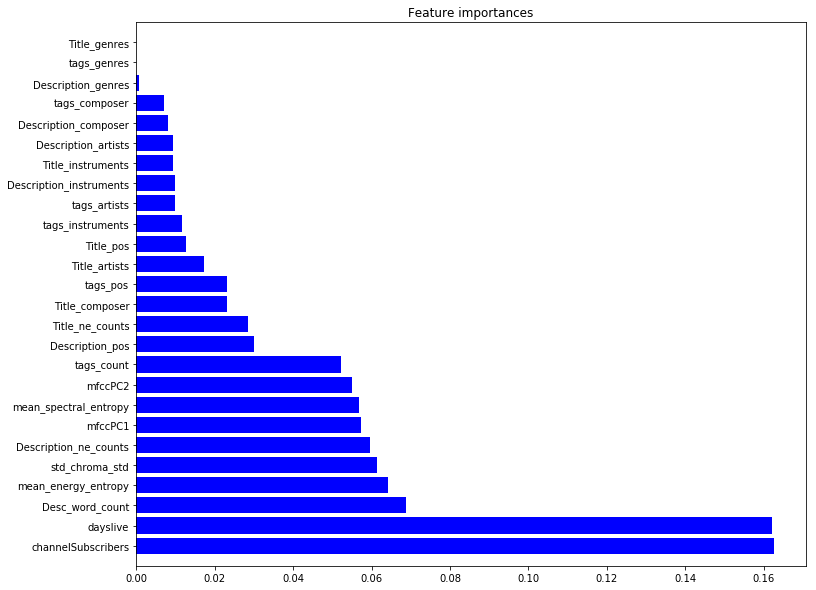

In [44]:
mnb = XGBClassifier()
mnb.set_params(**{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 65, 'n_jobs': 1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.4})
# fit the model
mnb.fit(X, y)
#Feature importance
importances = mnb.feature_importances_
#std = np.std([tree.feature_importances_ for tree in mnb.estimators_],
#             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12, 10))
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.ylim([-1, X.shape[1]])
plt.show()


In [44]:
import pickle

filename = 'xgb_model_final_week42.sav'
pickle.dump(xgcv, open(filename, 'wb'))

In [15]:
import pickle
filename = 'xgb_model_final_week4.sav'
xgcv = pickle.load(open(filename, 'rb'))
print(xgcv.best_estimator_)
print(xgcv.best_params_)
print(xgcv.best_score_)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.6, gamma=0.2, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=80, n_jobs=1, nthread=None, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 80, 'n_jobs': 1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.6}


Index(['Unnamed: 0', 'Desc_word_count', 'channelSubscribers', 'dayslive',
       'mean_energy_entropy', 'mean_spectral_entropy', 'Description_ne_counts',
       'Title_ne_counts', 'tags_composer', 'Title_composer',
       'Description_composer', 'tags_artists', 'Title_artists',
       'Description_artists', 'tags_instruments', 'Title_instruments',
       'Description_instruments', 'tags_genres', 'Title_genres',
       'Description_genres', 'tags_count', 'Title_pos', 'Description_pos',
       'tags_pos', 'mfccPC1', 'mfccPC2', 'std_chroma_std', 'views_cat',
       'viewCount'],
      dtype='object')
(541, 4)
(541, 4)


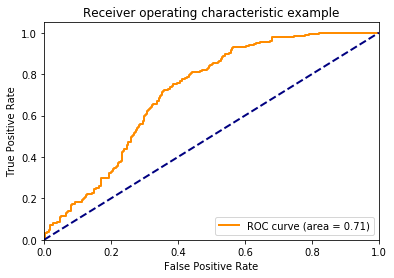

In [40]:
testdata=pd.read_csv('/Users/mac/Documents/Insight project/databasetestdata_week4.csv')
testdata=pd.read_csv('/Users/mac/Documents/Insight project/databasetestdata_week4_bin2.csv')
print(testdata.columns)
testdata=testdata[['Desc_word_count','channelSubscribers','dayslive', 'mean_energy_entropy', 'mean_spectral_entropy',
       'Description_ne_counts', 'Title_ne_counts',
       'tags_composer', 'Title_composer', 'Description_composer',
       'tags_artists', 'Title_artists', 'Description_artists',
       'tags_instruments', 'Title_instruments', 'Description_instruments',
       'tags_genres', 'Title_genres', 'Description_genres', 'tags_count',
       'Title_pos', 'Description_pos', 'tags_pos', 'mfccPC1', 'mfccPC2',
       'std_chroma_std','views_cat']]
#testdata=testdata.drop(['Unnamed: 0'],axis=1)

Y_t_cv=testdata['views_cat'].copy()
X_t_cv=testdata.drop(['views_cat'],axis=1).copy()
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


# Binarize the output
y_t_init=y.copy()
X_t_init=X.copy()
y_t_init = label_binarize(y_t_init, classes=[0, 1, 2,3])
n_classes = y_t_init.shape[1]
Y_t_cv = label_binarize(Y_t_cv, classes=[0, 1, 2,3])


# Learn to predict each class against the other
y_score = xgcv.predict_proba(X_t_cv)
#y_score = y_score mult by y_Test
print(y_score.shape)
print(Y_t_cv.shape)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_t_cv[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_t_cv.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#Plot
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

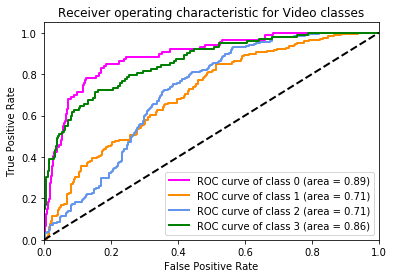

In [41]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
#plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=4)

#plt.plot(fpr["macro"], tpr["macro"],
#         label='macro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["macro"]),
#         color='navy', linestyle=':', linewidth=4)

colors = cycle(['magenta', 'darkorange', 'cornflowerblue','green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Video classes')
plt.legend(loc="lower right")
plt.show()

In [42]:
from __future__ import print_function
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn

print(sklearn.metrics.accuracy_score(Y_t_cv, xgcv.predict(X_t_cv)))
confusion_matrix = confusion_matrix(Y_t_cv, pd.Series(xgcv.predict(X_t_cv)))
print(confusion_matrix)
print(classification_report(Y_t_cv, pd.Series(xgcv.predict(X_t_cv))))


/Users/mac/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets